In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import librosa


from maad import sound

import glob
from os import listdir, chdir
from os.path import isfile, join

from utils import plot_listen_examples

plt.rcParams["figure.figsize"] = (19,7)

In [2]:
sns.set_palette("colorblind")

In [3]:
from preprocessing import load_annotations
from maad.util import read_audacity_annot


In [4]:
# git clone https://github.com/juansulloa/soundclim_annotations
window_size = 3
sliding_window = 1

bounding_boxes_sites = ['INCT20955','INCT41','INCT17', 'INCT4' ]
annotation_path = 'data/raw/soundclim_annotations/bounding_boxes/'

In [5]:
"""data/raw/soundclim_annotations/bounding_boxes/INCT20955 442
data/raw/soundclim_annotations/bounding_boxes/INCT41 808
data/raw/soundclim_annotations/bounding_boxes/INCT17 1162"""

'data/raw/soundclim_annotations/bounding_boxes/INCT20955 442\ndata/raw/soundclim_annotations/bounding_boxes/INCT41 808\ndata/raw/soundclim_annotations/bounding_boxes/INCT17 1162'

# Preprocessing:

In [7]:
"""
Used for replace wrong file name in audio and annotations
site = 'INCT17'
path_annot = annotation_path+site
annotation_site = [join(path_annot, f) for f in listdir(path_annot) if isfile(join(path_annot, f))]
wrong_annotation_name = [i for i in annotation_site if site+'_' not in i][1:]
OK= [os.rename(i, i.replace('S4A09810_',site+'_')) for i in wrong_annotation_name]

wrong_site = 'S4A09810'
path_audio = 'data/raw/audio/S4A09810'
wrong_audio = [join(path_audio, f) for f in listdir(path_audio) if isfile(join(path_audio, f))]
OK = [os.rename(i, i.replace('S4A09810_',site+'_')) for i in wrong_annotation_name]

# deleta audio without annotations
# to_delete = list(set(onlyfiles)-set(annotation_files))
# to_delete = [os.remove("data/raw/audio/INCT20955/"+ i+'.wav' ) for i in to_delete]
"""


'\nUsed for replace wrong file name in audio and annotations\nsite = \'INCT17\'\npath_annot = annotation_path+site\nannotation_site = [join(path_annot, f) for f in listdir(path_annot) if isfile(join(path_annot, f))]\nwrong_annotation_name = [i for i in annotation_site if site+\'_\' not in i][1:]\nOK= [os.rename(i, i.replace(\'S4A09810_\',site+\'_\')) for i in wrong_annotation_name]\n\nwrong_site = \'S4A09810\'\npath_audio = \'data/raw/audio/S4A09810\'\nwrong_audio = [join(path_audio, f) for f in listdir(path_audio) if isfile(join(path_audio, f))]\nOK = [os.rename(i, i.replace(\'S4A09810_\',site+\'_\')) for i in wrong_annotation_name]\n\n# deleta audio without annotations\n# to_delete = list(set(onlyfiles)-set(annotation_files))\n# to_delete = [os.remove("data/raw/audio/INCT20955/"+ i+\'.wav\' ) for i in to_delete]\n'

In [8]:
# Search files files
annotation_files = []
for site in bounding_boxes_sites:
    path_annot = annotation_path+site
    annotation_site = [join(path_annot, f) for f in listdir(path_annot) if isfile(join(path_annot, f))]
    # To avoid xlsx!!
    annotation_site = [file for file in annotation_site if '.txt' in file]
    annotation_files.extend(annotation_site)
    print(path_annot, '- cummulative sum:', len(annotation_files))

data/raw/soundclim_annotations/bounding_boxes/INCT20955 - cummulative sum: 472
data/raw/soundclim_annotations/bounding_boxes/INCT41 - cummulative sum: 838
data/raw/soundclim_annotations/bounding_boxes/INCT17 - cummulative sum: 1192
data/raw/soundclim_annotations/bounding_boxes/INCT4 - cummulative sum: 1612


In [9]:
# Read annotations
fnames_list = []
df_all_annotations = pd.DataFrame()
# TODO: avoid for loops, list comprenhension and multiprocessing
for file in annotation_files:
    df_annotation_file = read_audacity_annot(file) 
    if df_annotation_file.shape[0]>0:
        fnames_list.extend([file.split('.')[0]]*df_annotation_file.shape[0])
    else:
        fnames_list.extend([file.split('.')[0]])
        df_annotation_file = pd.DataFrame([np.nan, 0, np.nan, 60,  np.nan],
                                          index=list(df_all_annotations.columns)).T
    df_all_annotations = pd.concat([df_all_annotations, df_annotation_file],ignore_index=True)

df_all_annotations.insert(loc=0, column='fname', value=fnames_list)

In [10]:
df = df_all_annotations.copy()

In [11]:
print(df.shape)
df.head()

(16435, 6)


fname     label     min_t  \
0  data/raw/soundclim_annotations/bounding_boxes/...  SPHSUR_F  0.000000   
1  data/raw/soundclim_annotations/bounding_boxes/...  BOABIS_F  0.000000   
2  data/raw/soundclim_annotations/bounding_boxes/...  SCIPER_M  0.000000   
3  data/raw/soundclim_annotations/bounding_boxes/...  BOABIS_M  3.070290   
4  data/raw/soundclim_annotations/bounding_boxes/...  SPHSUR_M  3.755201   

   min_f      max_t  max_f  
0    NaN  59.988754    NaN  
1    NaN  59.988754    NaN  
2    NaN  59.988754    NaN  
3    NaN   3.330084    NaN  
4    NaN   7.770197    NaN

In [12]:
df[['dir','site','fname']] = df['fname'].str.rsplit('/',2, expand=True)
df[['site','date']] = df['fname'].str.split('_',1,expand=True)

df['date'] = df['date'].str.split('_').apply(lambda x: x[0]+x[1])
df['date'] = pd.to_datetime(df['date'])

df[['species','quality']] = df['label'].str.split('_',expand=True)
df['label_duration'] = df['max_t'] - df['min_t']

In [13]:
df.head().append(df.tail())

/tmp/ipykernel_10861/3069207714.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.head().append(df.tail())


fname     label      min_t  min_f      max_t  \
0      INCT20955_20190904_003000  SPHSUR_F   0.000000    NaN  59.988754   
1      INCT20955_20190904_003000  BOABIS_F   0.000000    NaN  59.988754   
2      INCT20955_20190909_050000  SCIPER_M   0.000000    NaN  59.988754   
3      INCT20955_20190909_050000  BOABIS_M   3.070290    NaN   3.330084   
4      INCT20955_20190909_050000  SPHSUR_M   3.755201    NaN   7.770197   
16430      INCT4_20210104_221500  BOAALM_F  51.486408    NaN  59.421928   
16431      INCT4_20210104_231500       NaN   0.000000    NaN  60.000000   
16432      INCT4_20210105_001500       NaN   0.000000    NaN  60.000000   
16433      INCT4_20210105_011500       NaN   0.000000    NaN  60.000000   
16434      INCT4_20210105_021500       NaN   0.000000    NaN  60.000000   

       max_f                                            dir       site  \
0        NaN  data/raw/soundclim_annotations/bounding_boxes  INCT20955   
1        NaN  data/raw/soundclim_annotations/bounding_boxes  INCT20955   
2        NaN  data/raw/soundclim_annotations/bounding_boxes  INCT20955   
3        NaN  data/raw/soundclim_annotations/bounding_boxes  INCT20955   
4        NaN  data/raw/soundclim_annotations/bounding_boxes  INCT20955   
16430    NaN  data/raw/soundclim_annotations/bounding_boxes      INCT4   
16431    NaN  data/raw/soundclim_annotations/bounding_boxes      INCT4   
16432    NaN  data/raw/soundclim_annotations/bounding_boxes      INCT4   
16433    NaN  data/raw/soundclim_annotations/bounding_boxes      INCT4   
16434    NaN  data/raw/soundclim_annotations/bounding_boxes      INCT4   

                     date species quality  label_duration  
0     2019-09-04 00:30:00  SPHSUR       F       59.988754  
1     2019-09-04 00:30:00  BOABIS       F       59.988754  
2     2019-09-09 05:00:00  SCIPER       M       59.988754  
3     2019-09-09 05:00:00  BOABIS       M        0.259794  
4     2019-09-09 05:00:00  SPHSUR       M        4.014996  
16430 2021-01-04 22:15:00  BOAALM       F        7.935520  
16431 2021-01-04 23:15:00     NaN    None       60.000000  
16432 2021-01-05 00:15:00     NaN    None       60.000000  
16433 2021-01-05 01:15:00     NaN    None       60.000000  
16434 2021-01-05 02:15:00     NaN    None       60.000000

# Check coherence:

In [14]:
# search INCT20955 in INCT.Anfibios/5_selection/INCT.selvino/regular
# INCT20955, 475 audio files downloaded, 475 files in NAS
# search INCT41 in INCT.Anfibios/5_selection/INCT.r.bastos/selection/regular_41
# INCT41, 366 audio files downloaded, 366 in NAS
# search INCT17 in INCT.Anfibios/5_selection/INCT.franco/selection/regular
# INCT17, 285 audio files downloaded, 285 in NAS
# search S4A09810 in INCT.Anfibios/5_selection/INCT.franco/selection/regular
# S4A09810, 69 audio files downloaded, 69 in NAS

# /volume1/INCT.ftoledo/selection/regular, 6.19 GB , 1257 archivos

for i in df['site'].unique():
    print('Site:',i)
    annotation_files = list(df[df['site']==i]['fname'].unique())
    print('Annotations files:', len(annotation_files))
    mypath = 'data/raw/audio/'+i
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    onlyfiles = [i.split('.wav')[0] for i in onlyfiles if '.wav' in i]
    print('Audio files:', len(onlyfiles))
    if len(onlyfiles)!=len(annotation_files):
        print('Annotations intersection Audio =',len(set(annotation_files)&set(onlyfiles)))
        print('Annotations unin Audio =',len(set(annotation_files)|set(onlyfiles)))
        print('Annotations - Audio =',len(set(annotation_files)-set(onlyfiles)))
        print('Audio - Annotations =',len(set(onlyfiles)-set(annotation_files)))
    print()
    
    

Site: INCT20955
Annotations files: 472
Audio files: 472

Site: INCT41
Annotations files: 366
Audio files: 366

Site: INCT17
Annotations files: 354
Audio files: 354

Site: INCT4
Annotations files: 420
Audio files: 420



# EDA:

In [15]:
round(100*df['quality'].value_counts(normalize=False),1)

F        883400
M        709900
C          7400
FALSE      2100
Name: quality, dtype: int64

In [16]:
df = df[df['quality']!='FALSE']

In [17]:
round(100*df['quality'].value_counts(normalize=True),1)

F    55.2
M    44.3
C     0.5
Name: quality, dtype: float64

<AxesSubplot:ylabel='quality'>

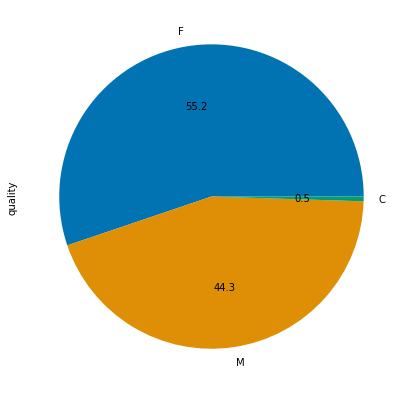

In [18]:
round(100*df['quality'].value_counts(normalize=True),1).plot(kind='pie',autopct='%.1f', )

In [19]:
df['site'].value_counts()

INCT17       6984
INCT20955    5418
INCT41       2210
INCT4        1802
Name: site, dtype: int64

<AxesSubplot:ylabel='site'>

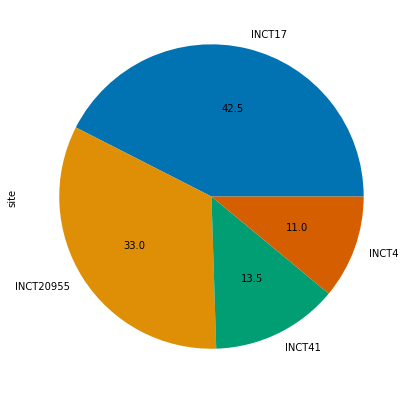

In [20]:
round(100*df['site'].value_counts(normalize=True),1).plot(kind='pie',autopct='%.1f', )


In [21]:
df['label'].value_counts(normalize=True)*100

DENMIN_M    6.534641
PHYALB_F    6.515899
SPHSUR_M    5.947398
BOABIS_M    4.879115
BOAALB_F    4.466796
              ...   
DENMIN_C    0.006247
RHIORN_F    0.006247
LEPLAB_C    0.006247
SCIFUS_F    0.006247
LEPNOT_M    0.006247
Name: label, Length: 87, dtype: float64

In [22]:
len(df['species'].unique())

43

In [23]:
round(100*df['species'].value_counts(normalize=True),1)

DENMIN    10.8
BOABIS     8.6
PHYALB     7.9
SPHSUR     7.8
LEPLAT     7.4
PITAZU     6.6
BOAALB     5.8
LEPPOD     4.8
BOALUN     4.5
DENNAN     3.7
BOAFAB     3.3
PHYSAU     3.3
BOAALM     2.9
SCIFUV     2.8
SCIPER     2.7
PHYCUV     2.7
PHYDIS     2.5
LEPFUS     1.6
BOALEP     1.5
BOARAN     1.5
ADEMAR     1.0
ELABIC     1.0
ELAMAT     0.7
BOAPRA     0.6
PHYNAT     0.6
PHYMAR     0.6
DENNAH     0.4
LEPLAB     0.4
DENELE     0.4
LEPNOT     0.4
DENCRU     0.3
RHIICT     0.2
AMEPIC     0.2
SCIRIZ     0.1
ADEDIP     0.1
LEPELE     0.1
RHIORN     0.0
SCINAS     0.0
SCIALT     0.0
RHISCI     0.0
SCIFUS     0.0
LEPFLA     0.0
Name: species, dtype: float64

In [24]:
df['label'].value_counts()

DENMIN_M    1046
PHYALB_F    1043
SPHSUR_M     952
BOABIS_M     781
BOAALB_F     715
            ... 
DENMIN_C       1
RHIORN_F       1
LEPLAB_C       1
SCIFUS_F       1
LEPNOT_M       1
Name: label, Length: 87, dtype: int64

In [25]:
df['label'].shape

(16414,)

In [26]:
df['date'].describe(datetime_is_numeric=True)

count                            16414
mean     2020-03-28 14:43:30.132447744
min                2019-09-04 00:30:00
25%                2019-12-18 21:00:00
50%                2020-02-05 11:15:00
75%                2020-10-12 19:15:00
max                2021-01-17 17:45:00
Name: date, dtype: object

In [27]:
round(100*df['label'].value_counts(normalize=True),1)

DENMIN_M    6.5
PHYALB_F    6.5
SPHSUR_M    5.9
BOABIS_M    4.9
BOAALB_F    4.5
           ... 
DENMIN_C    0.0
RHIORN_F    0.0
LEPLAB_C    0.0
SCIFUS_F    0.0
LEPNOT_M    0.0
Name: label, Length: 87, dtype: float64

<AxesSubplot:ylabel='species'>

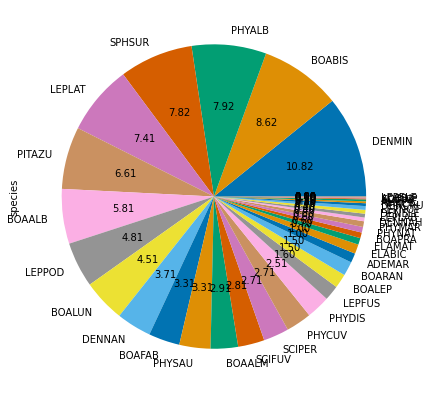

In [28]:
round(100*df['species'].value_counts(normalize=True),1).plot(kind='pie',autopct='%.2f', )

In [29]:
count = dict(round(100*df['species'].value_counts(normalize=True),1))

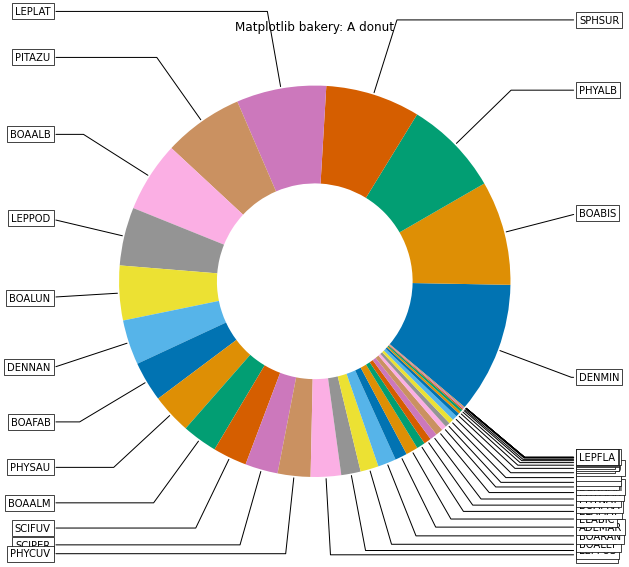

In [30]:
fig, ax = plt.subplots(figsize=(19, 9), subplot_kw=dict(aspect="equal"))

recipe = list(count.keys())


data = list(count.values())

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Matplotlib bakery: A donut")

plt.show()

In [31]:
df.head()

fname     label     min_t  min_f      max_t  max_f  \
0  INCT20955_20190904_003000  SPHSUR_F  0.000000    NaN  59.988754    NaN   
1  INCT20955_20190904_003000  BOABIS_F  0.000000    NaN  59.988754    NaN   
2  INCT20955_20190909_050000  SCIPER_M  0.000000    NaN  59.988754    NaN   
3  INCT20955_20190909_050000  BOABIS_M  3.070290    NaN   3.330084    NaN   
4  INCT20955_20190909_050000  SPHSUR_M  3.755201    NaN   7.770197    NaN   

                                             dir       site  \
0  data/raw/soundclim_annotations/bounding_boxes  INCT20955   
1  data/raw/soundclim_annotations/bounding_boxes  INCT20955   
2  data/raw/soundclim_annotations/bounding_boxes  INCT20955   
3  data/raw/soundclim_annotations/bounding_boxes  INCT20955   
4  data/raw/soundclim_annotations/bounding_boxes  INCT20955   

                 date species quality  label_duration  
0 2019-09-04 00:30:00  SPHSUR       F       59.988754  
1 2019-09-04 00:30:00  BOABIS       F       59.988754  
2 2019-09-09 05:00:00  SCIPER       M       59.988754  
3 2019-09-09 05:00:00  BOABIS       M        0.259794  
4 2019-09-09 05:00:00  SPHSUR       M        4.014996

In [78]:
df_total_time = df.groupby(['species'])['label_duration'].sum().to_frame()
df_total_time = df_total_time.sort_values(by=['label_duration'], ascending=False).reset_index()
df_total_time['label_duration'] = df_total_time['label_duration']/60

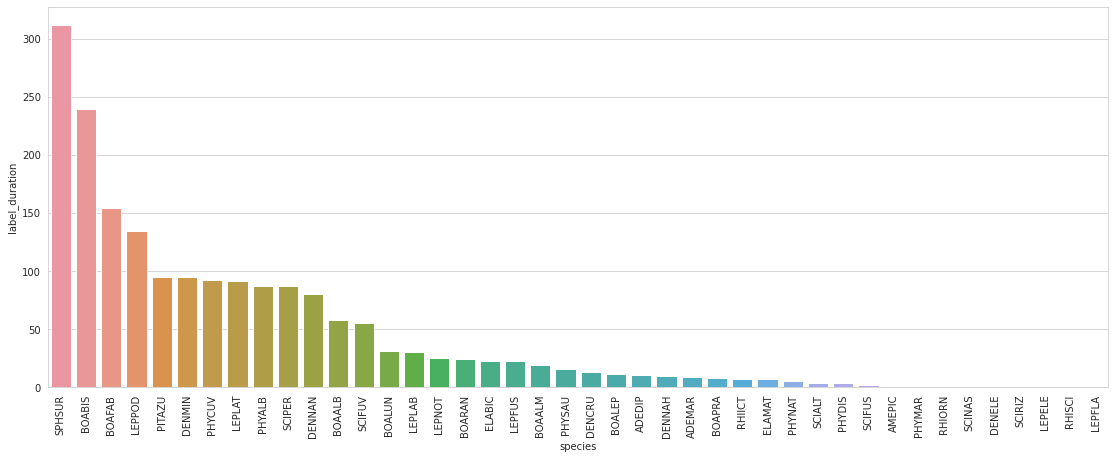

In [79]:
sns.barplot(data=df_total_time, x="species", y="label_duration")
plt.xticks(rotation=90)
plt.show()

In [82]:
list(df_total_time['species'])

['SPHSUR',
 'BOABIS',
 'BOAFAB',
 'LEPPOD',
 'PITAZU',
 'DENMIN',
 'PHYCUV',
 'LEPLAT',
 'PHYALB',
 'SCIPER',
 'DENNAN',
 'BOAALB',
 'SCIFUV',
 'BOALUN',
 'LEPLAB',
 'LEPNOT',
 'BOARAN',
 'ELABIC',
 'LEPFUS',
 'BOAALM',
 'PHYSAU',
 'DENCRU',
 'BOALEP',
 'ADEDIP',
 'DENNAH',
 'ADEMAR',
 'BOAPRA',
 'RHIICT',
 'ELAMAT',
 'PHYNAT',
 'SCIALT',
 'PHYDIS',
 'SCIFUS',
 'AMEPIC',
 'PHYMAR',
 'RHIORN',
 'SCINAS',
 'DENELE',
 'SCIRIZ',
 'LEPELE',
 'RHISCI',
 'LEPFLA']

In [34]:
df_total_time = df.groupby(['species','quality'])['label_duration'].sum().to_frame()
df_total_time = df_total_time.sort_values(by=['label_duration'], ascending=False).reset_index()
df_total_time['label_duration'] = df_total_time['label_duration']/60

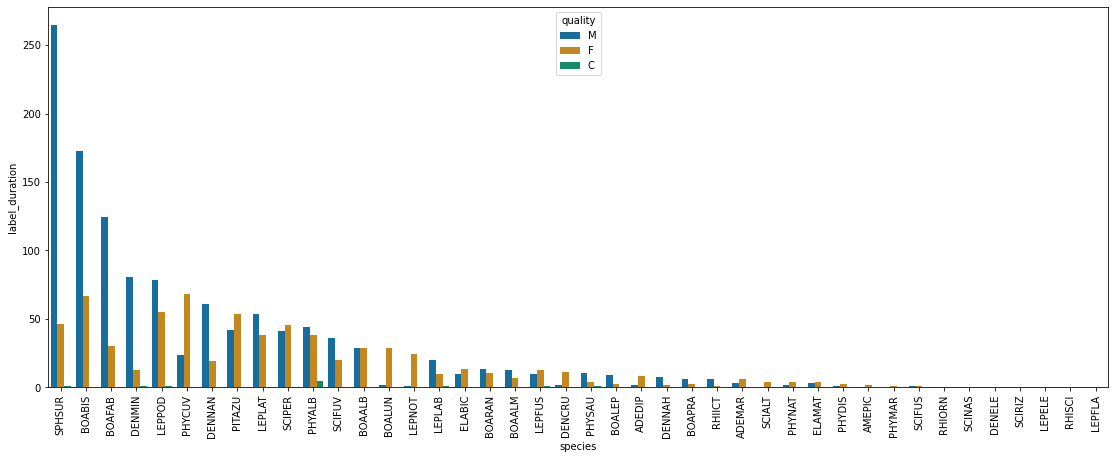

In [35]:
sns.barplot(data=df_total_time, x="species", y="label_duration", hue="quality")
plt.xticks(rotation=90)
plt.show()

In [36]:
df_total_time = df.groupby(['site','species'])['label_duration'].sum().to_frame()
df_total_time = df_total_time.sort_values(by=['label_duration'], ascending=False).reset_index()
df_total_time['label_duration'] = df_total_time['label_duration']/60

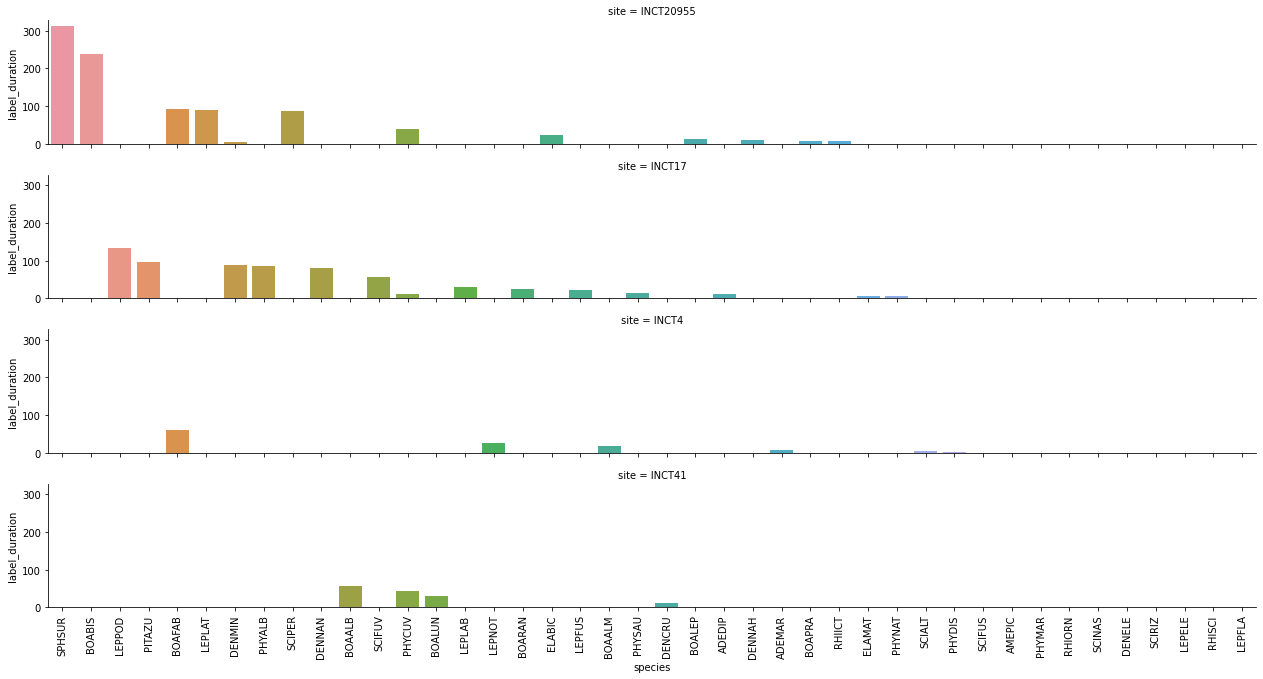

In [37]:
sns.catplot(data=df_total_time, x="species", y="label_duration", row="site", kind='bar',
           height=2.27, aspect=17.7/2.27)
plt.xticks(rotation=90)
plt.show()

In [38]:
df_heatmap = pd.crosstab(df_total_time['site'], df_total_time['species'],
                        dropna=False)

order_coincidences = df_heatmap.sum().sort_values(ascending=False).index
df_heatmap = df_heatmap[order_coincidences]
df_heatmap.sum().sort_values(ascending=False)[:6]

species
PHYCUV    3
DENMIN    3
PITAZU    2
BOAFAB    2
LEPLAT    2
DENCRU    1
dtype: int64

<AxesSubplot:xlabel='species', ylabel='site'>

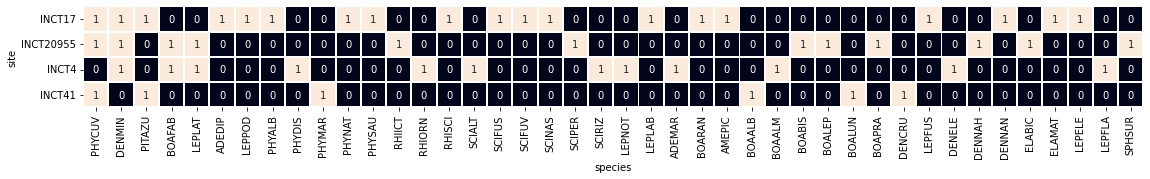

In [39]:
sns.heatmap(df_heatmap, square=True,  cbar=False, annot=True,linewidth=.9 )

In [40]:
df_heatmap = pd.crosstab(df_total_time['site'], df_total_time['species'], 
                        df_total_time['label_duration'], aggfunc=sum,
                        dropna=False).fillna(0).apply(np.ceil)

df_heatmap = df_heatmap[order_coincidences]

<AxesSubplot:xlabel='species', ylabel='site'>

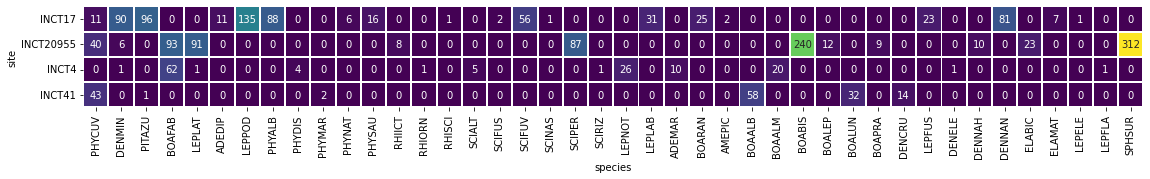

In [41]:
sns.heatmap(df_heatmap, square=True,  cbar=False, annot=True,linewidth=.9 ,fmt='g', cmap="viridis")

In [42]:
df_total_time = df.copy()
df_total_time['quality'] = df_total_time['quality'].replace({'C':'M'})
df_total_time = df_total_time.groupby(['site','species','quality'])['label_duration'].sum().to_frame()
df_total_time = df_total_time.sort_values(by=['label_duration'], ascending=False).reset_index()
df_total_time['label_duration'] = df_total_time['label_duration']/60
df_total_time_quality = df_total_time[df_total_time['quality']!='F']

In [43]:
df_heatmap = pd.crosstab(df_total_time_quality['site'], df_total_time_quality['species'],
                        dropna=False)

order_coincidences = df_heatmap.sum().sort_values(ascending=False).index
df_heatmap = df_heatmap[order_coincidences]
df_heatmap.sum().sort_values(ascending=False)[:6]

species
PHYCUV    3
DENMIN    3
LEPLAT    2
PITAZU    2
BOAFAB    2
DENCRU    1
dtype: int64

<AxesSubplot:xlabel='species', ylabel='site'>

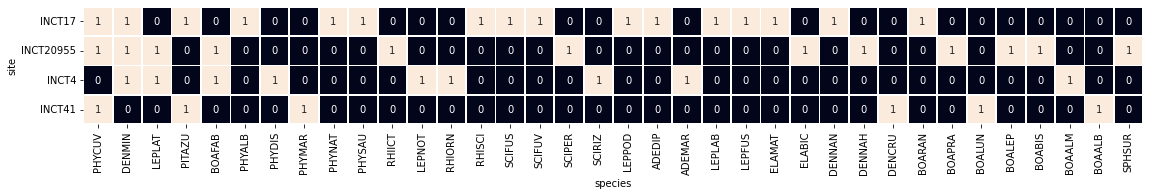

In [44]:
sns.heatmap(df_heatmap, square=True,  cbar=False, annot=True,linewidth=.9 )

In [45]:
df_heatmap = pd.crosstab(df_total_time_quality['site'], df_total_time_quality['species'], 
                        df_total_time_quality['label_duration'], aggfunc=sum,
                        dropna=False).fillna(0).apply(np.ceil)

df_heatmap = df_heatmap[order_coincidences]

<AxesSubplot:xlabel='species', ylabel='site'>

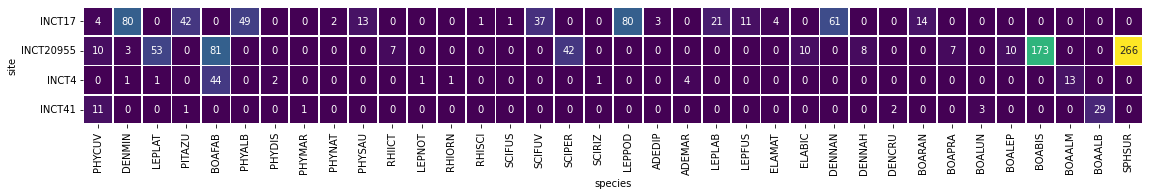

In [46]:
sns.heatmap(df_heatmap, square=True,  cbar=False, annot=True,linewidth=.9 ,fmt='g', cmap="viridis")

In [47]:
df['label_duration'].astype(float).describe()

count    16414.000000
mean         8.321977
std         18.019502
min          0.047142
25%          0.425117
50%          0.980133
75%          2.881349
max         60.812023
Name: label_duration, dtype: float64

In [48]:
df_priority = pd.read_excel('Especies priorizadas.xlsx')
df_priority.shape

(43, 9)

In [49]:
df_priority.head()

Familia                  Specie    Code  INCT41  INCT17  INCT20955  \
0          Hylidae      Boana albopunctata  BOAALB     1.0     0.0        0.0   
1          Hylidae            Boana lundii  BOALUN     1.0     0.0        0.0   
2          Hylidae     Dendropsophus cruzi  DENCRU     1.0     0.0        0.0   
3  Leptodactylidae     Physalaemus cuvieri  PHYCUV     1.0     1.0        1.0   
4  Leptodactylidae  Physalaemus marmoratus  PHYMAR     1.0     0.0        0.0   

   INCT4  Priority  Freq_occ_INCTs  
0    0.0       3.0             6.0  
1    0.0       3.0             3.0  
2    0.0       2.0             5.0  
3    0.0       3.0            15.0  
4    0.0       3.0             2.0

In [50]:

df_total_time = df.groupby(['species','quality'])['label_duration'].sum().to_frame().reset_index()
df_total_time.columns = ['Code','quality','label_duration']

df_priority = pd.merge(df_priority, df_total_time, on='Code', how='left')
df_priority['Priority'] = df_priority['Priority'].replace({1:3,3:1})
df_priority = df_priority.sort_values(by=['Priority', 'label_duration'], ascending=False)
df_priority['Priority'] = df_priority['Priority'].replace({1:3,3:1})
df_priority['Priority'] = df_priority['Priority'].fillna(4)
df_priority = df_priority.dropna(subset=['label_duration'])
df_priority['Priority'] = df_priority['Priority'].replace({4:'Without priority class'})
df_priority = df_priority[df_priority['label_duration']>0]

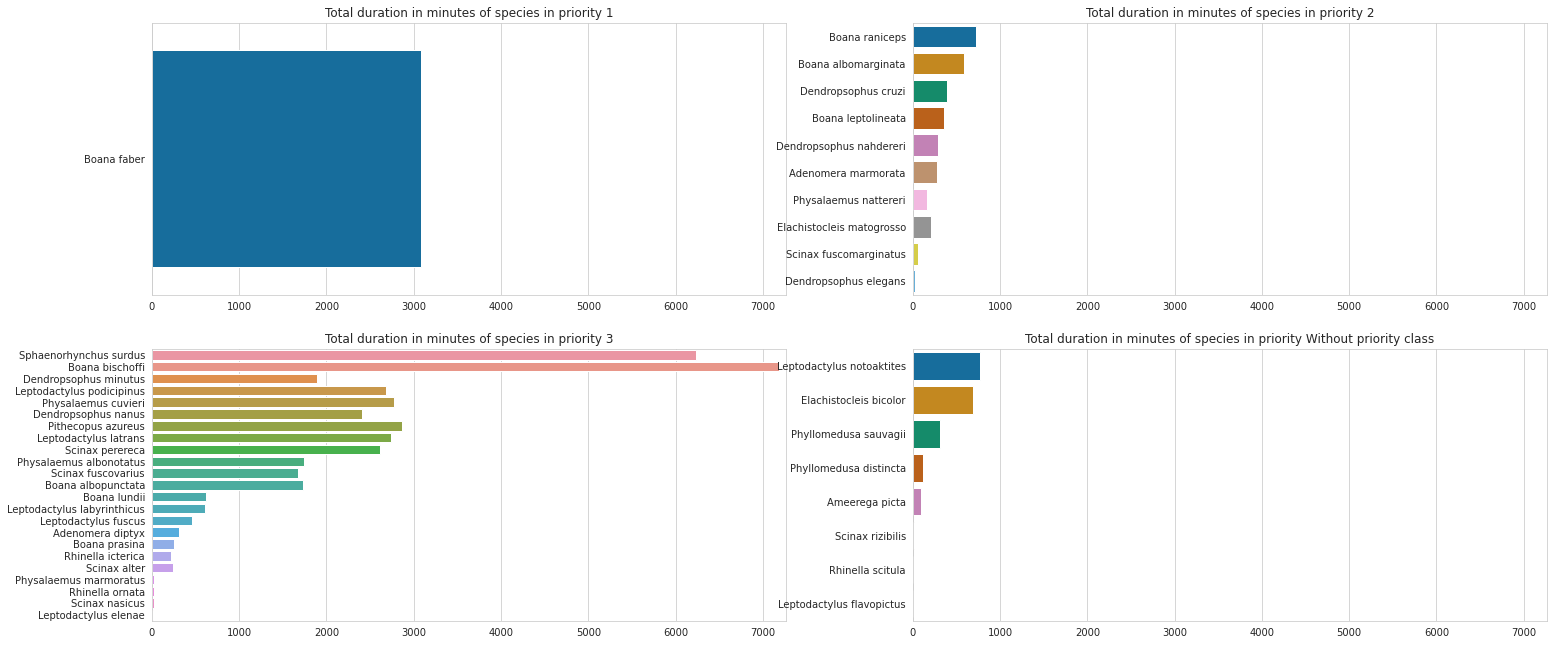

In [51]:
sns.set_style("whitegrid")
max_value = max(df_priority['label_duration'])


fig, axs = plt.subplots(2, 2, figsize=(25, 11))

for i, priority in enumerate([2,1,3,'Without priority class']):
    df_priority_ = df_priority[df_priority["Priority"]==priority]
    sns.barplot(data=df_priority_, y="Specie", x="label_duration",ci=None,
               # hue='quality', 
                #row="Priority", 
                #kind='bar', 
                ax=axs[i//2, int(abs((i-0.1)//2))],
                #height=2.27, aspect=17.7/2.27
               )
    axs[i//2, int(abs((i-0.1)//2))].set_title('Total duration in minutes of species in priority ' +str(priority))
    axs[i//2, int(abs((i-0.1)//2))].set(xlim=(0, 7266))
for ax in axs.flat:
    ax.set(xlabel='', ylabel='')

plt.show()

In [52]:
df_priority['label_duration'].describe()

count       87.000000
mean      1289.389918
std       2340.673793
min          0.454641
25%         63.256327
50%        368.460244
75%       1719.254931
max      15877.265519
Name: label_duration, dtype: float64

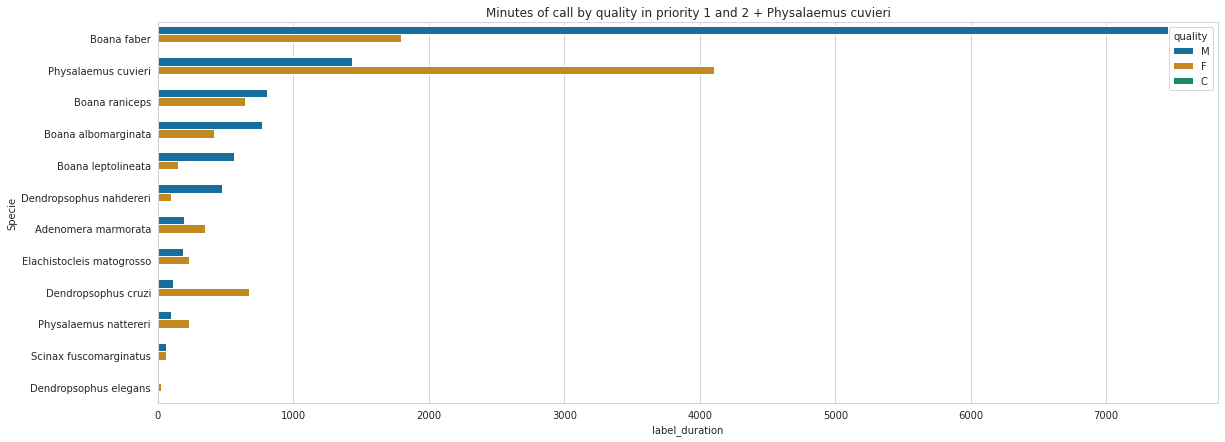

In [53]:
sns.set_style("whitegrid")

order = ['Boana faber',
        'Physalaemus cuvieri',
        'Boana raniceps', 'Boana albomarginata',
        'Boana leptolineata',
        'Dendropsophus nahdereri', 'Adenomera marmorata',
        'Elachistocleis matogrosso',
        'Dendropsophus cruzi', 
        'Physalaemus nattereri', 
        'Scinax fuscomarginatus', 'Dendropsophus elegans',
       ]

df_priority_ = df_priority[(df_priority["Priority"].isin([1,2]))|(df_priority['Code']=='PHYCUV')]
sns.barplot(data=df_priority_, y="Specie", x="label_duration", order = order,
        hue='quality', 
        #row="Priority", 
        #height=2.27, aspect=17.7/2.27
       )

plt.title('Minutes of call by quality in priority 1 and 2 + Physalaemus cuvieri')
plt.show()

In [54]:
TOTAL = df_priority['label_duration'].sum()
100*df_priority.groupby(['Priority'])['label_duration'].sum() / TOTAL

Priority
1.0                        8.248819
2.0                        5.451266
3.0                       82.566360
Without priority class     3.733555
Name: label_duration, dtype: float64

In [55]:
TOTAL = df_priority['label_duration'].sum()
(100*df_priority_.groupby(['Priority'])['label_duration'].sum()/TOTAL).sum()

18.636307478330018

<AxesSubplot:xlabel='label_duration', ylabel='Count'>

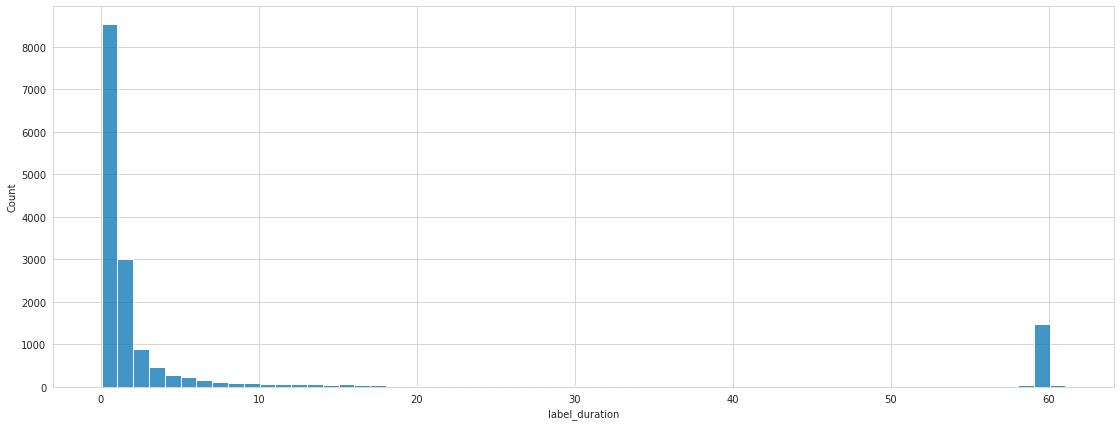

In [56]:
sns.histplot(data=df, x="label_duration",binwidth=1)

In [57]:
df[df['label']!='ABSENCE']['label_duration'].sum()/3600

37.943589693377206

In [58]:
total_label_duration = df['label_duration'].sum()  
total_recording_time = df[['date']].drop_duplicates().shape[0]*60
print('Total duration of recordings:', total_recording_time)
print('Total labels duration:', total_label_duration)

print('Percentage of labels:', round(100*total_label_duration/total_recording_time,1))

Total duration of recordings: 85620
Total labels duration: 136596.92289615795
Percentage of labels: 159.5


In [59]:
df.groupby(['label'])['label_duration'].sum()

label
ADEDIP_F      509.423270
ADEDIP_M      120.166447
ADEMAR_F      349.548010
ADEMAR_M      194.270478
AMEPIC_F       93.437670
                ...     
SCIRIZ_F        8.738519
SCIRIZ_M        9.730458
SPHSUR_C       59.823429
SPHSUR_F     2778.602340
SPHSUR_M    15877.265519
Name: label_duration, Length: 87, dtype: float64

In [60]:
df.groupby(['date', 'label'])['label_duration'].sum()

date                 label   
2019-09-04 00:30:00  BOABIS_F    59.988754
                     SPHSUR_F    59.988754
2019-09-09 05:00:00  BOABIS_M     1.086410
                     DENNAH_M     5.809938
                     SCIPER_M    59.988754
                                   ...    
2021-01-12 23:30:00  BOAALB_F    15.162517
2021-01-13 00:30:00  BOAALB_F    17.618741
2021-01-13 01:30:00  BOAALB_F    41.519773
2021-01-13 02:30:00  BOAALB_F    24.538711
2021-01-15 05:00:00  BOAALB_F    23.098032
Name: label_duration, Length: 3656, dtype: float64

In [61]:
df.groupby(['date', 'quality'])['label_duration'].sum()

date                 quality
2019-09-04 00:30:00  F          119.977509
2019-09-09 05:00:00  M           89.959517
2019-09-09 17:15:00  M           39.145600
2019-09-11 00:30:00  F           41.399366
                     M          116.340394
                                   ...    
2021-01-12 23:30:00  F           15.162517
2021-01-13 00:30:00  F           17.618741
2021-01-13 01:30:00  F           41.519773
2021-01-13 02:30:00  F           24.538711
2021-01-15 05:00:00  F           23.098032
Name: label_duration, Length: 1745, dtype: float64

# Read Audio

In [62]:
search_n_examples = 1
recordings_folder = 'data/raw/audio/**/*.wav'
annotation_examples = [random.choice(list(df['fname'].unique())) for i in range(search_n_examples)]
all_audio_files = glob.glob(recordings_folder, recursive=True)
audio_dir_examples = [dir_file for annotation in annotation_examples for dir_file in all_audio_files if annotation in dir_file]

data/raw/audio/INCT17/INCT17_20200320_203000.wav


/anaconda/envs/trans_env/lib/python3.8/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)
/anaconda/envs/trans_env/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/anaconda/envs/trans_env/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


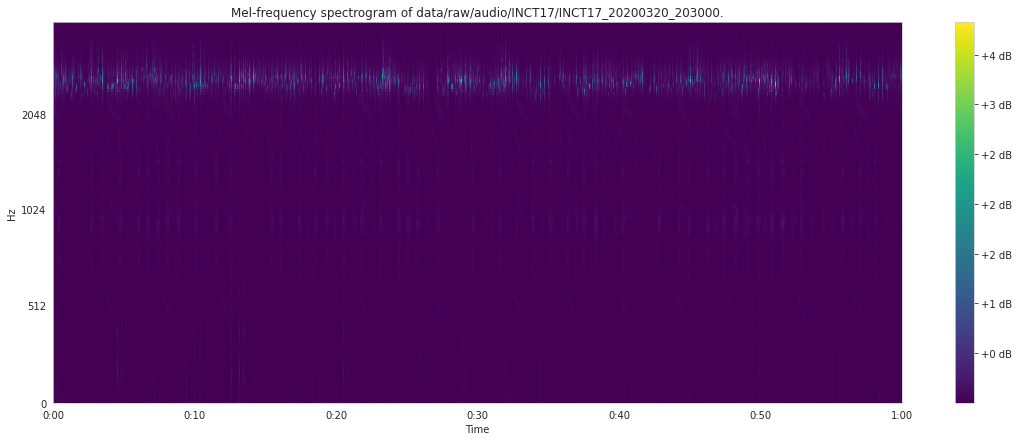

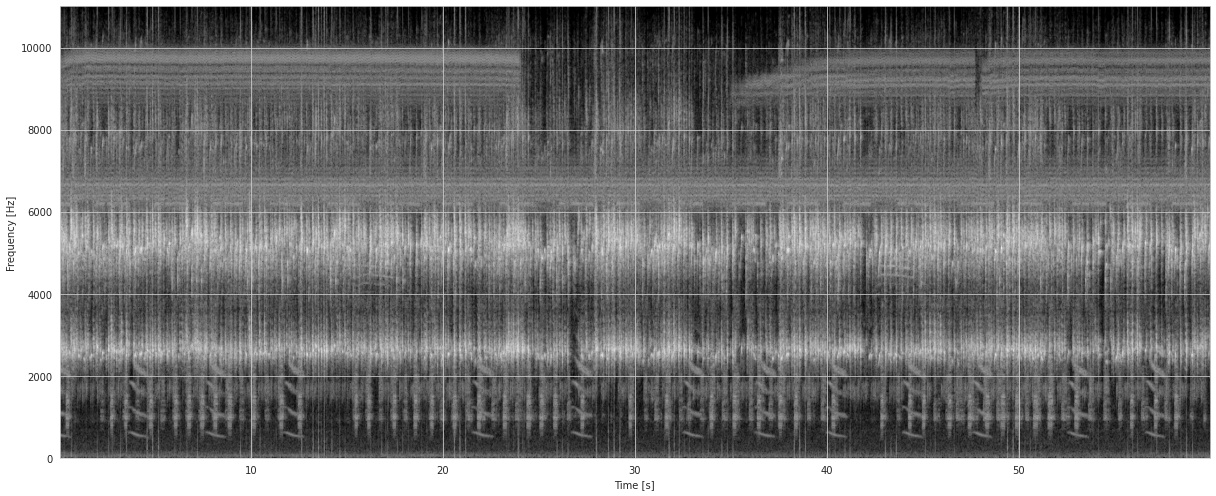

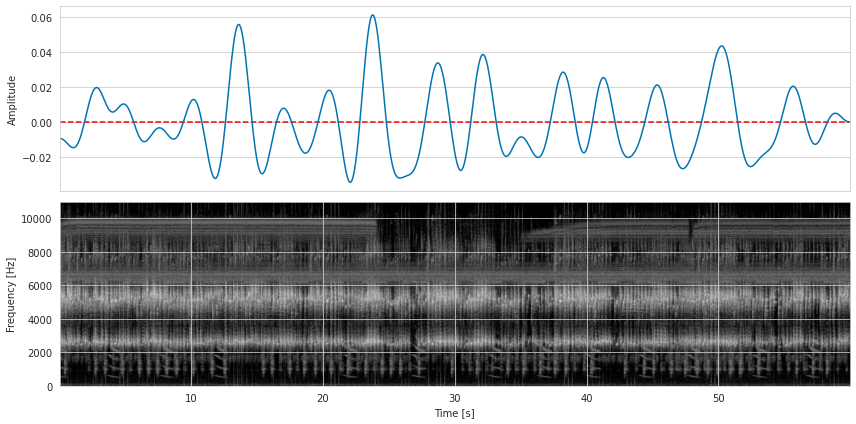

fname     label      min_t  min_f      max_t  max_f  \
12910  INCT17_20200320_203000  LEPPOD_F   0.000000    NaN  59.988754    NaN   
12911  INCT17_20200320_203000  DENMIN_M   0.000000    NaN  59.988754    NaN   
12912  INCT17_20200320_203000  SCIFUV_F   0.283411    NaN   0.708529    NaN   
12913  INCT17_20200320_203000  SCIFUV_F   2.597938    NaN  12.800750    NaN   
12914  INCT17_20200320_203000  PHYALB_F   3.542643    NaN   4.865230    NaN   
12915  INCT17_20200320_203000  PHYALB_F   7.510403    NaN   8.974695    NaN   
12916  INCT17_20200320_203000  PHYALB_F  11.478163    NaN  13.036926    NaN   
12917  INCT17_20200320_203000  SCIFUV_F  15.068041    NaN  27.679850    NaN   
12918  INCT17_20200320_203000  ELAMAT_F  15.304217    NaN  17.477037    NaN   
12919  INCT17_20200320_203000  PHYALB_F  21.492033    NaN  22.814619    NaN   
12920  INCT17_20200320_203000  PHYALB_F  26.546204    NaN  28.057732    NaN   
12921  INCT17_20200320_203000  SCIFUV_F  29.522024    NaN  40.622307    NaN   
12922  INCT17_20200320_203000  PHYALB_F  32.403374    NaN  33.914902    NaN   
12923  INCT17_20200320_203000  PHYALB_F  36.276665    NaN  37.457542    NaN   
12924  INCT17_20200320_203000  PHYALB_F  39.961014    NaN  41.236362    NaN   
12925  INCT17_20200320_203000  SCIFUV_F  42.275539    NaN  59.752579    NaN   
12926  INCT17_20200320_203000  PHYALB_F  43.834301    NaN  45.345829    NaN   
12927  INCT17_20200320_203000  PHYALB_F  47.518650    NaN  48.794003    NaN   
12928  INCT17_20200320_203000  PHYALB_F  52.478352    NaN  53.753700    NaN   
12929  INCT17_20200320_203000  PHYALB_F  56.635052    NaN  57.910400    NaN   

                                                 dir    site  \
12910  data/raw/soundclim_annotations/bounding_boxes  INCT17   
12911  data/raw/soundclim_annotations/bounding_boxes  INCT17   
12912  data/raw/soundclim_annotations/bounding_boxes  INCT17   
12913  data/raw/soundclim_annotations/bounding_boxes  INCT17   
12914  data/raw/soundclim_annotations/bounding_boxes  INCT17   
12915  data/raw/soundclim_annotations/bounding_boxes  INCT17   
12916  data/raw/soundclim_annotations/bounding_boxes  INCT17   
12917  data/raw/soundclim_annotations/bounding_boxes  INCT17   
12918  data/raw/soundclim_annotations/bounding_boxes  INCT17   
12919  data/raw/soundclim_annotations/bounding_boxes  INCT17   
12920  data/raw/soundclim_annotations/bounding_boxes  INCT17   
12921  data/raw/soundclim_annotations/bounding_boxes  INCT17   
12922  data/raw/soundclim_annotations/bounding_boxes  INCT17   
12923  data/raw/soundclim_annotations/bounding_boxes  INCT17   
12924  data/raw/soundclim_annotations/bounding_boxes  INCT17   
12925  data/raw/soundclim_annotations/bounding_boxes  INCT17   
12926  data/raw/soundclim_annotations/bounding_boxes  INCT17   
12927  data/raw/soundclim_annotations/bounding_boxes  INCT17   
12928  data/raw/soundclim_annotations/bounding_boxes  INCT17   
12929  data/raw/soundclim_annotations/bounding_boxes  INCT17   

                     date species quality  label_duration  
12910 2020-03-20 20:30:00  LEPPOD       F       59.988754  
12911 2020-03-20 20:30:00  DENMIN       M       59.988754  
12912 2020-03-20 20:30:00  SCIFUV       F        0.425118  
12913 2020-03-20 20:30:00  SCIFUV       F       10.202812  
12914 2020-03-20 20:30:00  PHYALB       F        1.322587  
12915 2020-03-20 20:30:00  PHYALB       F        1.464292  
12916 2020-03-20 20:30:00  PHYALB       F        1.558764  
12917 2020-03-20 20:30:00  SCIFUV       F       12.611809  
12918 2020-03-20 20:30:00  ELAMAT       F        2.172820  
12919 2020-03-20 20:30:00  PHYALB       F        1.322586  
12920 2020-03-20 20:30:00  PHYALB       F        1.511528  
12921 2020-03-20 20:30:00  SCIFUV       F       11.100283  
12922 2020-03-20 20:30:00  PHYALB       F        1.511528  
12923 2020-03-20 20:30:00  PHYALB       F        1.180878  
12924 2020-03-20 20:30:00  PHYALB       F        1.275349  
12925 2020-03-20 20:30:00  SCIFUV       F       17.477039  

In [63]:
for dir_file in audio_dir_examples:
    fname = dir_file.split('/')[-1].split('.wav')[0]
    print(dir_file)
    file_name = plot_listen_examples(dir_file)
    display(df[df['fname']==fname])

In [64]:
file = 'INCT41_20200126_180000'
df[df['fname']==file]

fname label  min_t  min_f  max_t  max_f  \
5418  INCT41_20200126_180000   NaN    0.0    NaN   60.0    NaN   

                                                dir    site  \
5418  data/raw/soundclim_annotations/bounding_boxes  INCT41   

                    date species quality  label_duration  
5418 2020-01-26 18:00:00     NaN    None            60.0

In [67]:
"""file_annotated, start_reading, start_reading+window_size, df['species'].unique()

fname,min_t,max_t,fold, subset,df['species'].unique()

    -fname: file of 60s extracted from a site and used for annotators 
    -min_t: second where the annotation starts in fixed window length 
    -max_t: second where the annotation ends in fixed window length 
    -label: annotations with species and quality 
    -species: species code 
    -quality: quality code 
    -site: identifier of recorder 
    -date: date of recording 
    -class: class of detection. This is the column of interest in the ML problem 
    -fold: int number of fold. Fold 0 is a test set, you must not use it in training or cross-validation 
    -subset: if the sample is from train or test. If test, the fold column must be 0 
    - Binary columns of each class """

"file_annotated, start_reading, start_reading+window_size, df['species'].unique()\n\nfname,min_t,max_t,fold, subset,df['species'].unique()\n\n    -fname: file of 60s extracted from a site and used for annotators \n    -min_t: second where the annotation starts in fixed window length \n    -max_t: second where the annotation ends in fixed window length \n    -label: annotations with species and quality \n    -species: species code \n    -quality: quality code \n    -site: identifier of recorder \n    -date: date of recording \n    -class: class of detection. This is the column of interest in the ML problem \n    -fold: int number of fold. Fold 0 is a test set, you must not use it in training or cross-validation \n    -subset: if the sample is from train or test. If test, the fold column must be 0 \n    - Binary columns of each class "

In [68]:
from tqdm import tqdm

In [69]:
"""
overlaps_anuraset = []
for file_annotated in tqdm(df['fname'].unique()):
    # select annotations of one file of ~60s
    df_file = df[df['fname']==file_annotated]
    # select file
    audio_dir = [dir_file for dir_file in all_audio_files if file_annotated in dir_file][0]
    def assign_label(file_annotated, df_file, max_duration=60):
        # select audio dor
        audio_dir = [dir_file for dir_file in all_audio_files if file_annotated in dir_file][0]
        # select annotations of one file of ~60s
        df_file = df[df['fname']==file_annotated]
                     
        for min_t in range(max_duration-window_size+1):
            try:
                y, sr = librosa.load(audio_dir, offset=min_t, duration=window_size)
                #[file_annotated,start_reading,start_reading+window_size]
                max_t = min_t+window_size
                df_overlap = df_file.copy()
                df_overlap['overlap_t'] = df_overlap.apply(lambda x:min(x['max_t'], max_t)-max(x['min_t'], min_t), axis=1)
                # Rule: the interval obtains the annotation if more than a half of interval coincides with the annotation
                df_overlap = df_overlap[df_overlap['overlap_t']>window_size/2]
                species_overlap  = [1 if i in list(df_overlap['species']) else 0 for i in df['species'].unique()]
                overlaps_anuraset.append([file_annotated,min_t,max_t] + species_overlap)
            except:
                print('check:',file_annotated,min_t)
"""

"\noverlaps_anuraset = []\nfor file_annotated in tqdm(df['fname'].unique()):\n    # select annotations of one file of ~60s\n    df_file = df[df['fname']==file_annotated]\n    # select file\n    audio_dir = [dir_file for dir_file in all_audio_files if file_annotated in dir_file][0]\n    def assign_label(file_annotated, df_file, max_duration=60):\n        # select audio dor\n        audio_dir = [dir_file for dir_file in all_audio_files if file_annotated in dir_file][0]\n        # select annotations of one file of ~60s\n        df_file = df[df['fname']==file_annotated]\n                     \n        for min_t in range(max_duration-window_size+1):\n            try:\n                y, sr = librosa.load(audio_dir, offset=min_t, duration=window_size)\n                #[file_annotated,start_reading,start_reading+window_size]\n                max_t = min_t+window_size\n                df_overlap = df_file.copy()\n                df_overlap['overlap_t'] = df_overlap.apply(lambda x:min(x['max_t

In [70]:
"""
from maad import util

# 5 minutes
#%% Set variables
path_audio = 'data/raw/audio'
#%% Get audio metadata
df_metadata = util.get_metadata_dir(path_audio)

df_metadata['length'].describe()
"""

"\nfrom maad import util\n\n# 5 minutes\n#%% Set variables\npath_audio = 'data/raw/audio'\n#%% Get audio metadata\ndf_metadata = util.get_metadata_dir(path_audio)\n\ndf_metadata['length'].describe()\n"

In [71]:
def assign_label(file_annotated, max_duration=60):
    
    file_annotation = []
    species_list = df['species'].dropna().unique()
    # select audio dor
    audio_dir = [dir_file for dir_file in all_audio_files if file_annotated in dir_file][0]
    # select annotations of one file of ~60s
    df_file = df[df['fname']==file_annotated]
    #display(df_file)
    for min_t in range(max_duration-window_size+1):
        try:
            y, sr = librosa.load(audio_dir, offset=min_t, duration=window_size)
            #[file_annotated,start_reading,start_reading+window_size]
            max_t = min_t+window_size
            
            # change name to co-occurence
            df_file_annotation = df_file.copy()
            #print(min_t, max_t)
            #df_overlap = df_overlap[(min_t>=df_overlap['min_t'])&(max_t<=df_overlap['max_t'])]
            df_file_annotation = df_file_annotation[(min_t<=df_file_annotation['max_t'])&(max_t>=df_file_annotation['min_t'])]
            #p_overlap = lambda x: ((min(x['max_t'], max_t)-max(x['min_t'], min_t))/min(window_size,x['label_duration']))
            #df_overlap['p_overlap_t'] = df_overlap.apply(p_overlap, axis=1)
            #df_overlap = df_overlap[df_overlap['p_overlap_t']>0]
            #print(min_t, max_t)
            #display(df_overlap)
            ### Return p overlap if species in annotation, else 0
            #t_0 = list(df_overlap['min_t'].apply(lambda x: x if x > min_t else min_t))
            #t_f = list(df_overlap['max_t'].apply(lambda x: x if max_t > x else max_t))
            #intervals = [(t_0[i],t_f[i]) for i in range(len(t_0))]
            
            #print('intervals',intervals)
            #print('intersection',find_intersection(intervals))
            
            species_overlap = [1
                                #df_overlap[df_overlap['species']==specie]['p_overlap_t'].values[0] 
                                        if specie in df_file_annotation['species'].unique() 
                                        else 0 
                                        for specie in species_list 
                                ]
            #print(species_overlap)
            
            file_annotation.append([file_annotated,min_t,max_t] + species_overlap)
        except:
            print('check:',file_annotated,min_t)
            file_annotation.append([file_annotated,min_t,0] + len(species_list)*[None])
            print([file_annotated,min_t,0] + len(species_list)*[None])

    return file_annotation

In [72]:
def interval_intersection(i1, i2):
    start = max(i1[0], i2[0])
    end = min(i1[1], i2[1])
    if start <= end:
        return (start, end)
    else:
        return None

In [73]:
files = list(df['fname'].unique())
len(files)

1612

In [74]:
example_result = assign_label(files[1000:][0], max_duration=60)

In [75]:
import multiprocessing
multiprocessing.cpu_count()

6

In [76]:
from joblib import Parallel, delayed

In [77]:
#overlaps_anuraset = Parallel(n_jobs=6)(delayed(assign_label)(file_annotated) for file_annotated in files)
#overlaps_anuraset = [item for sublist in overlaps_anuraset for item in sublist]

/anaconda/envs/trans_env/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/anaconda/envs/trans_env/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/anaconda/envs/trans_env/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/anaconda/envs/trans_env/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/anaconda/envs/trans_env/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying a

KeyboardInterrupt: 

In [ ]:
for i in overlaps_anuraset:
    for j in i:
        if j is None:
            print(i)

In [ ]:
len(overlaps_anuraset)

93496

In [ ]:
print('gs')

gs


In [ ]:
ove2 = [t for t in overlaps_anuraset if None in t]

len(ove2)


0

In [ ]:
[1 for t in overlaps_anuraset if any(i == 0 for i in t )]



In [ ]:
"""
overlaps_anuraset = Parallel(n_jobs=6)(delayed(assign_label)(file_annotated) for file_annotated in files)
overlaps_anuraset = [item for sublist in overlaps_anuraset for item in sublist]

column_names = ['fname', 'min_t', 'max_t']+ list(df['species'].unique())
species = list(set(df['species'].unique())-set(['ABSENCE']))
df_anuraset = pd.DataFrame(overlaps_anuraset, columns=column_names)

df_anuraset.shape
"""

In [ ]:
column_names = ['fname', 'min_t', 'max_t']+ list(df['species'].dropna().unique())
species = list(df['species'].unique())
df_anuraset = pd.DataFrame(overlaps_anuraset, columns=column_names)
df_anuraset.shape

(93496, 45)

In [ ]:
df_anuraset.to_csv('data/datasets/anurasetv3/metadata.csv',index=False)